<div class="usecase-title"><h3>Predicting Future Patron Capacity of Bars and Pubs in Melbourne</h3></div>

<div class="usecase-authors"><b>Authored by: </b> Venuka Hirushan Wijenayake</div>

<div class="usecase-authors"><b>Date: </b> T2 2024 (July - September)</div>

<div class="usecase-duration"><b>Duration:</b> 270 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python, Machine Learning</div>
</div>

### Use Case Scenario

**Title: Analyzing Historical and Current Tree Diversity in Melbourne**

**As a** member of the local city council's urban planning department,

**I want to** conduct a comprehensive analysis of the diversity of tree species within the Melbourne area, comparing the current variety and density of tree species to historical data from pre-colonial times,

**So that I can** identify significant changes and trends in tree diversity over time, specifically pinpointing species that have become less common or are on the verge of disappearing from the local ecosystem.

**This will help** in making informed decisions about which species to prioritize in future tree planting programs, aiming to restore ecological balance, enhance urban biodiversity, and support sustainable urban development.

**By** utilizing interactive mapping tools and temporal data visualization techniques, I hope to present this data in a clear and actionable manner to stakeholders and the public, ensuring the planning and execution of greening initiatives are well-supported by historical trends and current needs.

<div class="usecase-section-header"><h3>Project Goal: Title: Optimizing Bar and Pub Operations through Foot Traffic Analysis in Melbourne</h3></div>

<p>Conduct an in-depth analysis of the relationship between pedestrian foot traffic and the patron capacity of bars and pubs in Melbourne. This study aims to develop predictive models that estimate potential patron capacity based on foot traffic patterns. The ultimate goal is to provide evidence-based recommendations to bar and pub owners for optimizing operations, including location selection, staffing, inventory management, and marketing strategies. Additionally, the project will offer insights to urban planners to enhance the nightlife ecosystem in Melbourne, contributing to a more vibrant and economically thriving city.</p>

<h4>Key Activities</h4>
<ul>
  <li>Data Integration: Combine data from the "Bars, Taverns, and Pub Patron Capacity" dataset with the "Pedestrian Counting System - Sensor Locations" dataset to create a comprehensive dataset for analysis.</li>
  <li>Data Preprocessing: Clean and preprocess the combined dataset to ensure accuracy and relevance for analysis.</li>
  <li>Exploratory Data Analysis: Perform exploratory data analysis to understand the relationships and patterns within the data.</li>
  <li>Predictive Modeling: Develop and validate predictive models to estimate patron capacity based on foot traffic patterns.</li>
  <li>Visualization and Reporting: Create visualizations and reports to present key findings and recommendations to stakeholders.</li>
</ul>

<h4>Expected Outcome</h4>
<p>A comprehensive report detailing the relationship between pedestrian foot traffic and the patron capacity of bars and pubs in Melbourne, with actionable recommendations for optimizing bar and pub operations. The report will also provide insights for urban planners to enhance Melbourne's nightlife ecosystem.</p>

<h4>Impact</h4>
<p>This project will empower bar and pub owners to make data-driven decisions, improving operational efficiency and enhancing customer experiences. Urban planners will benefit from insights that support sustainable development and vibrant nightlife in Melbourne, contributing to the city's economic and social vitality.</p>

<h4>Datasets</h4>
<div class="usecase-subsection-blurb">
  <i>1. Bars, Taverns, and Pub Patron Capacity</i> 
  <br>
  <a href="https://data.melbourne.vic.gov.au/explore/dataset/bars-and-pubs-with-patron-capacity/information/" target="_blank">Link to Dataset 1</a>
  <br>
</div>
<br>
<div class="usecase-subsection-blurb">
  <i>2. Pedestrian Counting System - Sensor Locations</i> 
  <br>
  <a href="https://data.melbourne.vic.gov.au/explore/dataset/pedestrian-counting-system-sensor-locations/information/" target="_blank">Link to Dataset 2</a>
  <br>
</div>
<br>


## Install necessary libraries (Optional)

In [1]:
# !pip install requests pandas geopandas folium matplotlib seaborn

## Importing all the necessory libraries

In [2]:
import requests
import pandas as pd
from io import StringIO
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Dataset Import Through API

In [3]:
#Function to collect data
def collect_data(dataset_id):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    #apikey = api_key #use if use datasets API_key permissions
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC',
        #'api_key': apikey  #use if use datasets API_key permissions
    }

    # GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(url_content), delimiter=';')
        return dataset
    else:
        print(f'Request failed with status code {response.status_code}')

In [4]:
# Set dataset_id to query for the API call dataset name
dataset_id1 = 'bars-and-pubs-with-patron-capacity'
# Save dataset to df varaible
bars_pubs = collect_data(dataset_id1)
# Check number of records in df
print(f'The dataset contains {len(bars_pubs)} records.')
# View df
bars_pubs.head(3)

The dataset contains 4696 records.


,census_year,block_id,property_id,base_property_id,building_address,clue_small_area,trading_name,business_address,number_of_patrons,longitude,latitude,location
0,2002,11,108972,108972,10-22 Spencer Street MELBOURNE 3000,Melbourne (CBD),Explorers Inn,10-22 Spencer Street MELBOURNE 3000,50,144.955254,-37.820511,"-37.82051068881513, 144.95525416628004"
1,2002,14,103172,103172,31-39 Elizabeth Street MELBOURNE 3000,Melbourne (CBD),Connells Tavern,35 Elizabeth Street MELBOURNE 3000,350,144.964322,-37.817426,"-37.81742610667125, 144.964321660097"
2,2002,15,103944,103944,277-279 Flinders Lane MELBOURNE 3000,Melbourne (CBD),De Biers,"Unit 1, Basement , 277 Flinders Lane MELBOURNE...",400,144.965307,-37.817242,"-37.81724194023457, 144.96530699086"


### Preprocessing Data

#### Displaying available columns

In [5]:
# Print available columns in Bars and Pubs dataset:
print("Available columns in Bars and Pubs dataset:")
print(bars_pubs.columns.tolist())

Available columns in Bars and Pubs dataset:
['census_year', 'block_id', 'property_id', 'base_property_id', 'building_address', 'clue_small_area', 'trading_name', 'business_address', 'number_of_patrons', 'longitude', 'latitude', 'location']


#### Removing Unwanted Columns

In [6]:
# Remove irrelevant columns
columns_to_remove = ['block_id', 'base_property_id', 'clue_small_area', 'business_address']
bars_pubs_updated = bars_pubs.drop(columns=columns_to_remove)

# Verify the columns have been removed
print("Remaining columns in Bars and Pubs dataset:")
print(bars_pubs_updated.columns.tolist())

Remaining columns in Bars and Pubs dataset:
['census_year', 'property_id', 'building_address', 'trading_name', 'number_of_patrons', 'longitude', 'latitude', 'location']


#### Identifying Missing Values

In [7]:
# Check for missing values in the dataset
missing_values = bars_pubs_updated.isnull().sum()

# Print the number of missing values in each column
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
census_year           0
property_id           0
building_address      0
trading_name          0
number_of_patrons     0
longitude            20
latitude             20
location             20
dtype: int64


#### Displaying Important Details of Missing Rows

In [8]:
# Filter rows with missing values in 'longitude', 'latitude', or 'location'
missing_values_df = bars_pubs_updated[bars_pubs_updated['longitude'].isnull() | 
                                      bars_pubs_updated['latitude'].isnull() | 
                                      bars_pubs_updated['location'].isnull()]

# Select distinct 'building_address' and 'trading_name'
distinct_missing_values = missing_values_df[['building_address', 'trading_name']].drop_duplicates()

# Display the result
print("'Building Address' and 'Trading Name' where 'Longitude', 'Latitude', or 'Location' are missing:")
print(distinct_missing_values)

'Building Address' and 'Trading Name' where 'Longitude', 'Latitude', or 'Location' are missing:
                              building_address  \
41    353 Little Collins Street MELBOURNE 3000   
123            4-6 Goldie Place MELBOURNE 3000   
229            4-6 Goldie Place MELBOURNE 3000   
953           13 Heffernan Lane MELBOURNE 3000   
990          Evan Walker Bridge SOUTHBANK 3006   
991     816 Lorimer Street PORT MELBOURNE 3207   
1007        25-27 Rankins Road KENSINGTON 3031   
2415      27-45 Whiteman Street SOUTHBANK 3006   
2606     717-731 Collins Street DOCKLANDS 3008   
2607         524 Macaulay Road KENSINGTON 3031   
3177      42-44 Lonsdale Street MELBOURNE 3000   
3420  143-175 Harbour Esplanade DOCKLANDS 3008   
4104     607-623 Collins Street MELBOURNE 3000   
4186  143-175 Harbour Esplanade DOCKLANDS 3008   
4188   265-271 Racecourse Road KENSINGTON 3031   

                          trading_name  
41                    Grosvenor Tavern  
123                Pa

In [9]:
!pip install geopy

Defaulting to user installation because normal site-packages is not writeable


#### Filling up missing values manually

In [10]:
# Provided latitude and longitude values for the missing data
address_coordinates = {
    "13 Heffernan Lane MELBOURNE 3000": (-37.811798, 144.966599),
    "143-175 Harbour Esplanade DOCKLANDS 3008": (-37.81741, 144.94591),
    "25-27 Rankins Road KENSINGTON 3031": (-37.78929, 144.93211),
    "265-271 Racecourse Road KENSINGTON 3031": (-37.78858, 144.93225),
    "27-45 Whiteman Street SOUTHBANK 3006": (-37.8251819, 144.9582948),
    "353 Little Collins Street MELBOURNE 3000": (-37.8155378, 144.9629855),
    "42-44 Lonsdale Street MELBOURNE 3000": (-37.8097472, 144.9710871),
    "4-6 Goldie Place MELBOURNE 3000": (-37.8132486, 144.9605705),
    "524 Macaulay Road KENSINGTON 3031": (-37.794177, 144.9286062),
    "607-623 Collins Street MELBOURNE 3000": (-37.8190018, 144.9541476),
    "717-731 Collins Street DOCKLANDS 3008": (-37.8149, 144.9505),
    "816 Lorimer Street PORT MELBOURNE 3207": (-37.8221281, 144.9309547),
    "Evan Walker Bridge SOUTHBANK 3006": (-37.8196329, 144.9651296)
}

# Create a copy of the updated DataFrame and name it bars_pubs_cleaned
bars_pubs_cleaned = bars_pubs_updated.copy()

# Update the new DataFrame with the provided latitude and longitude values
for address, (lat, lon) in address_coordinates.items():
    bars_pubs_cleaned.loc[bars_pubs_cleaned['building_address'] == address, 'latitude'] = lat
    bars_pubs_cleaned.loc[bars_pubs_cleaned['building_address'] == address, 'longitude'] = lon

# Verify the updated values
print("Updated dataset with filled latitude and longitude:")
print(bars_pubs_cleaned.loc[bars_pubs_cleaned['building_address'].isin(address_coordinates.keys()), ['building_address', 'latitude', 'longitude']])

Updated dataset with filled latitude and longitude:
                              building_address   latitude   longitude
19        42-44 Lonsdale Street MELBOURNE 3000 -37.809747  144.971087
41    353 Little Collins Street MELBOURNE 3000 -37.815538  144.962986
123            4-6 Goldie Place MELBOURNE 3000 -37.813249  144.960570
168            4-6 Goldie Place MELBOURNE 3000 -37.813249  144.960570
229            4-6 Goldie Place MELBOURNE 3000 -37.813249  144.960570
...                                        ...        ...         ...
4297           4-6 Goldie Place MELBOURNE 3000 -37.813249  144.960570
4302          13 Heffernan Lane MELBOURNE 3000 -37.811798  144.966599
4341  143-175 Harbour Esplanade DOCKLANDS 3008 -37.817410  144.945910
4342  143-175 Harbour Esplanade DOCKLANDS 3008 -37.817410  144.945910
4385           4-6 Goldie Place MELBOURNE 3000 -37.813249  144.960570

[99 rows x 3 columns]


In [11]:
# Create a copy of the updated DataFrame and name it bars_pubs_cleaned
bars_pubs_cleaned = bars_pubs_updated.copy()

# Update the new DataFrame with the provided latitude and longitude values and fill location column
for address, (lat, lon) in address_coordinates.items():
    bars_pubs_cleaned.loc[bars_pubs_cleaned['building_address'] == address, 'latitude'] = lat
    bars_pubs_cleaned.loc[bars_pubs_cleaned['building_address'] == address, 'longitude'] = lon
    bars_pubs_cleaned.loc[bars_pubs_cleaned['building_address'] == address, 'location'] = f"{lat}, {lon}"

# Verify the updated values
print("Updated dataset with filled latitude, longitude, and location:")
print(bars_pubs_cleaned.loc[bars_pubs_cleaned['building_address'].isin(address_coordinates.keys()), ['building_address', 'latitude', 'longitude', 'location']])

Updated dataset with filled latitude, longitude, and location:
                              building_address   latitude   longitude  \
19        42-44 Lonsdale Street MELBOURNE 3000 -37.809747  144.971087   
41    353 Little Collins Street MELBOURNE 3000 -37.815538  144.962986   
123            4-6 Goldie Place MELBOURNE 3000 -37.813249  144.960570   
168            4-6 Goldie Place MELBOURNE 3000 -37.813249  144.960570   
229            4-6 Goldie Place MELBOURNE 3000 -37.813249  144.960570   
...                                        ...        ...         ...   
4297           4-6 Goldie Place MELBOURNE 3000 -37.813249  144.960570   
4302          13 Heffernan Lane MELBOURNE 3000 -37.811798  144.966599   
4341  143-175 Harbour Esplanade DOCKLANDS 3008 -37.817410  144.945910   
4342  143-175 Harbour Esplanade DOCKLANDS 3008 -37.817410  144.945910   
4385           4-6 Goldie Place MELBOURNE 3000 -37.813249  144.960570   

                      location  
19    -37.8097472, 144.9710

#### Rechecking Missing Values

In [12]:
# Check for missing values in the dataset
missing_values_new = bars_pubs_cleaned.isnull().sum()

# Print the number of missing values in each column
print("Missing values in each column:")
print(missing_values_new)

Missing values in each column:
census_year          0
property_id          0
building_address     0
trading_name         0
number_of_patrons    0
longitude            0
latitude             0
location             0
dtype: int64


In [13]:
# Group by 'property_id' and find the index of the row with the maximum 'number_of_patrons' for each group
idx = bars_pubs_cleaned.groupby(['property_id'])['number_of_patrons'].idxmax()

# Use the indices to filter the DataFrame
bars_pubs_deduplicated = bars_pubs_cleaned.loc[idx].reset_index(drop=True)

# Verify the deduplicated DataFrame
print(bars_pubs_deduplicated)

     census_year  property_id  \
0           2009       100160   
1           2011       100441   
2           2002       100514   
3           2005       100727   
4           2016       100730   
..           ...          ...   
359         2019       640970   
360         2016       664626   
361         2020       692410   
362         2021       709873   
363         2022       709874   

                                      building_address  \
0              196-200 A'Beckett Street MELBOURNE 3000   
1           118-126 Ireland Street WEST MELBOURNE 3003   
2            204-206 Arden Street NORTH MELBOURNE 3051   
3                        5-9 Bank Place MELBOURNE 3000   
4                      12-16 Bank Place MELBOURNE 3000   
..                                                 ...   
359            14-24 Batmans Hill Drive DOCKLANDS 3008   
360                  230 Grattan Street PARKVILLE 3010   
361  Novotel Melbourne South Wharf Hotel 7 Conventi...   
362        95-109 Exhib

### Exploratory Data Analysis

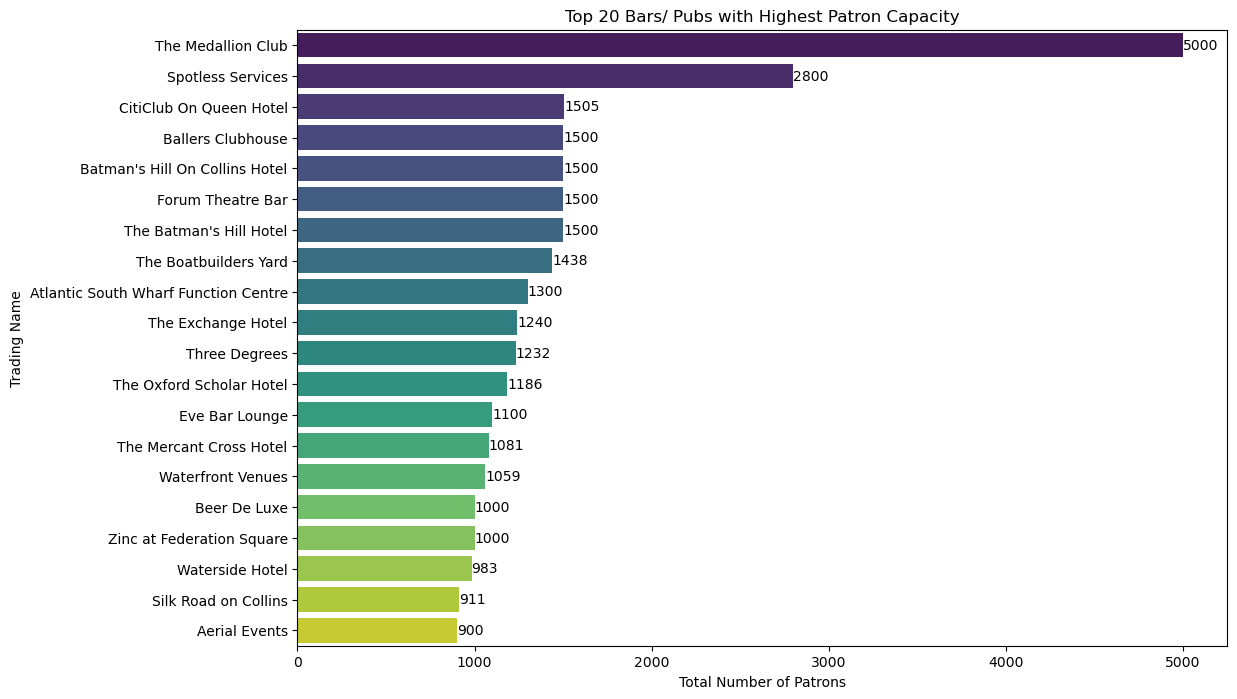

In [14]:
# Aggregate the data to find the top 20 trading names with the highest patron capacity
top_20_trading_names = bars_pubs_deduplicated.groupby('trading_name')['number_of_patrons'].sum().nlargest(20).reset_index()

# Create the bar plot
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x='number_of_patrons', y='trading_name', data=top_20_trading_names, palette='viridis')

# Add the count on each bar
for index, row in top_20_trading_names.iterrows():
    bar_plot.text(row['number_of_patrons'], index, f'{row["number_of_patrons"]}', va='center')

plt.title('Top 20 Bars/ Pubs with Highest Patron Capacity')
plt.xlabel('Total Number of Patrons')
plt.ylabel('Trading Name')
plt.show()

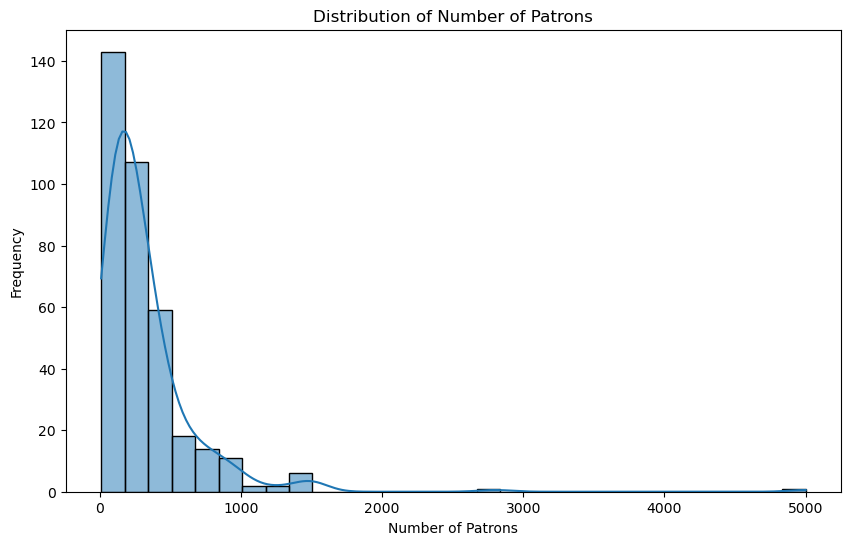

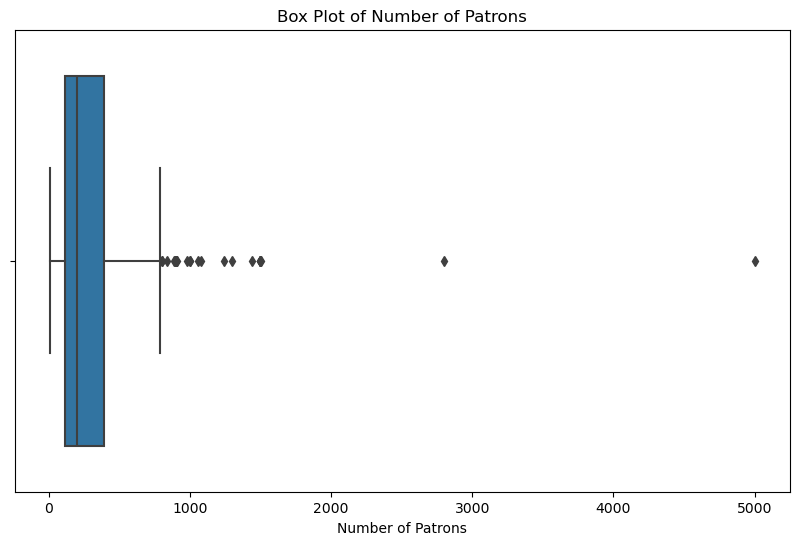

In [15]:
# Distribution of the number of patrons
plt.figure(figsize=(10, 6))
sns.histplot(bars_pubs_deduplicated['number_of_patrons'], bins=30, kde=True)
plt.title('Distribution of Number of Patrons')
plt.xlabel('Number of Patrons')
plt.ylabel('Frequency')
plt.show()

# Box plot for the number of patrons
plt.figure(figsize=(10, 6))
sns.boxplot(x=bars_pubs_deduplicated['number_of_patrons'])
plt.title('Box Plot of Number of Patrons')
plt.xlabel('Number of Patrons')
plt.show()

In [16]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(
    bars_pubs_deduplicated,
    geometry=gpd.points_from_xy(bars_pubs_deduplicated.longitude, bars_pubs_deduplicated.latitude),
    crs="EPSG:4326"
)

# Initialize a map centered around Melbourne
melbourne_map = folium.Map(location=[-37.8136, 144.9631], zoom_start=12)

# Use MarkerCluster to manage multiple markers
marker_cluster = MarkerCluster().add_to(melbourne_map)

# Add markers to the MarkerCluster
for idx, row in gdf.iterrows():
    marker = folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color='blue',
        fill=True,
        fill_color='blue',
        popup=f"Trading Name: {row['trading_name']}, Patrons: {row['number_of_patrons']}"
    )
    marker.add_to(marker_cluster)

# Add LayerControl to the map
folium.LayerControl().add_to(melbourne_map)

# Display the map (only works in a Jupyter notebook)
melbourne_map